In [4]:
# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [5]:
# Step 2: Load the Data
file_path = '/content/drive/MyDrive/Stats SA /Retail_sales /retail22.xlsx'  # Change this if needed
df = pd.read_excel(file_path, sheet_name='Sheet1')

In [6]:
# Step 3: Basic Information
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nSummary Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              206 non-null    datetime64[ns]
 1   General_dealers   206 non-null    int64         
 2   retail_food       206 non-null    int64         
 3   retail_phama      206 non-null    int64         
 4   retail_clothing   206 non-null    int64         
 5   retail_furniture  206 non-null    int64         
 6   retail_hardware   206 non-null    int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 11.4 KB
None

Missing Values:
Date                0
General_dealers     0
retail_food         0
retail_phama        0
retail_clothing     0
retail_furniture    0
retail_hardware     0
dtype: int64

Summary Statistics:
                                Date  General_dealers   retail_food  \
count                            206       206.000000    

In [7]:

# Step 4: Data Cleaning
# Ensure 'Date' is datetime
df['Date'] = pd.to_datetime(df['Date'])


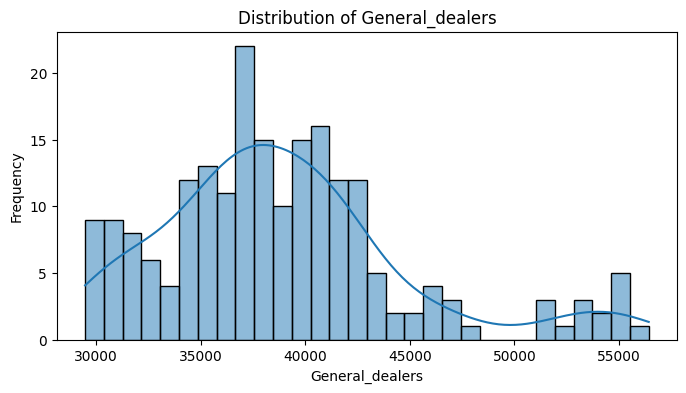

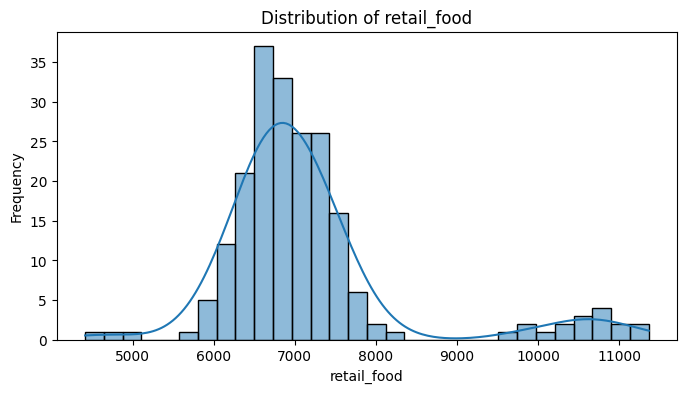

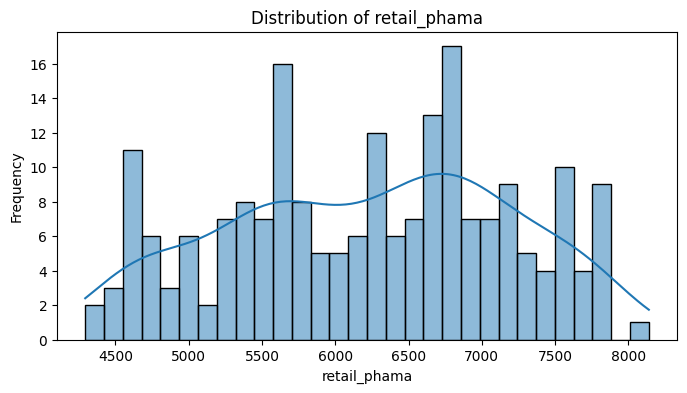

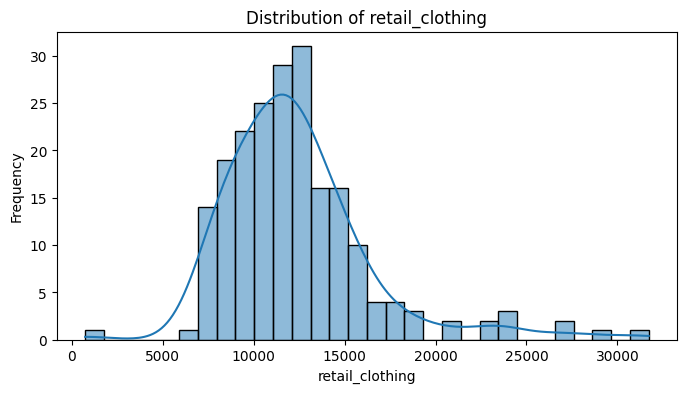

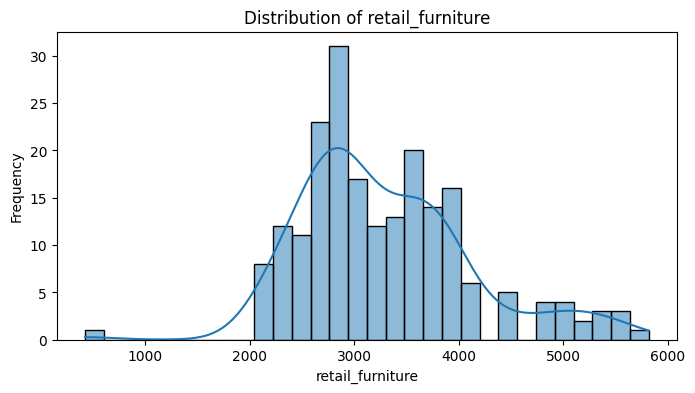

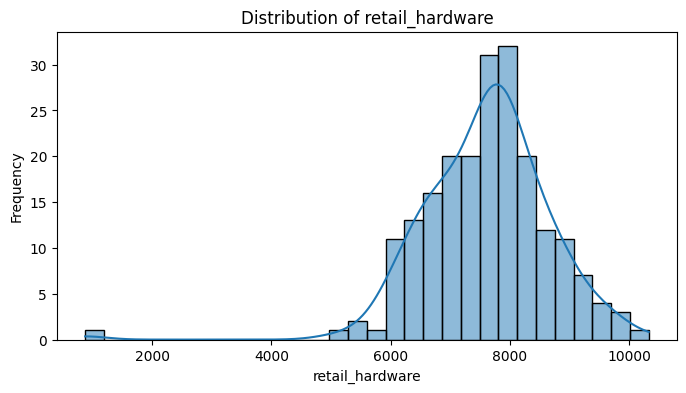

In [8]:
# Step 5: Univariate Analysis
# Numerical Features
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


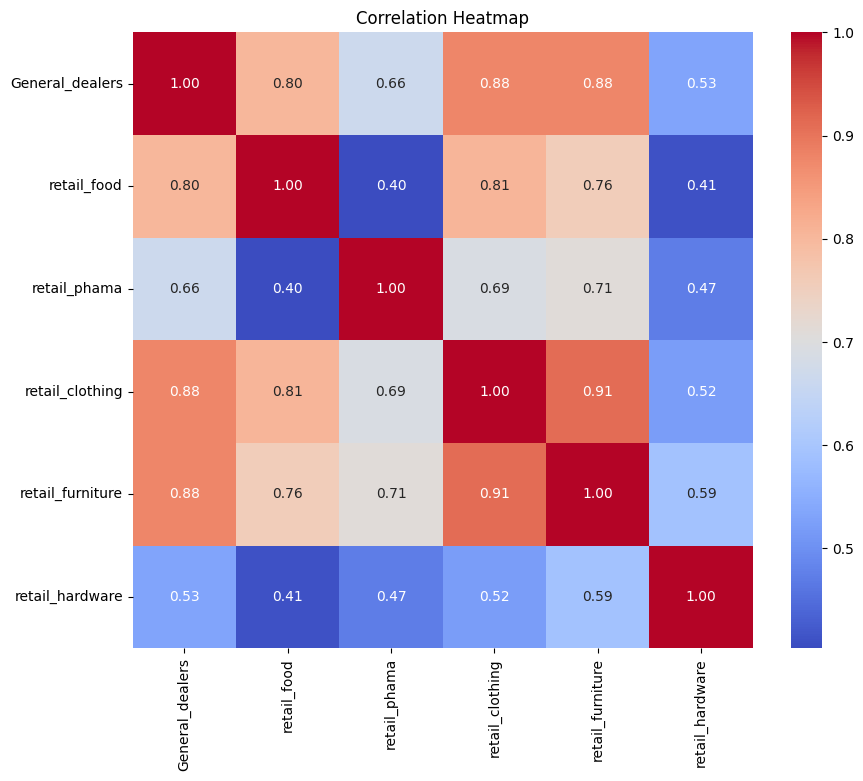

In [9]:
# Step 6: Bivariate Analysis
# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

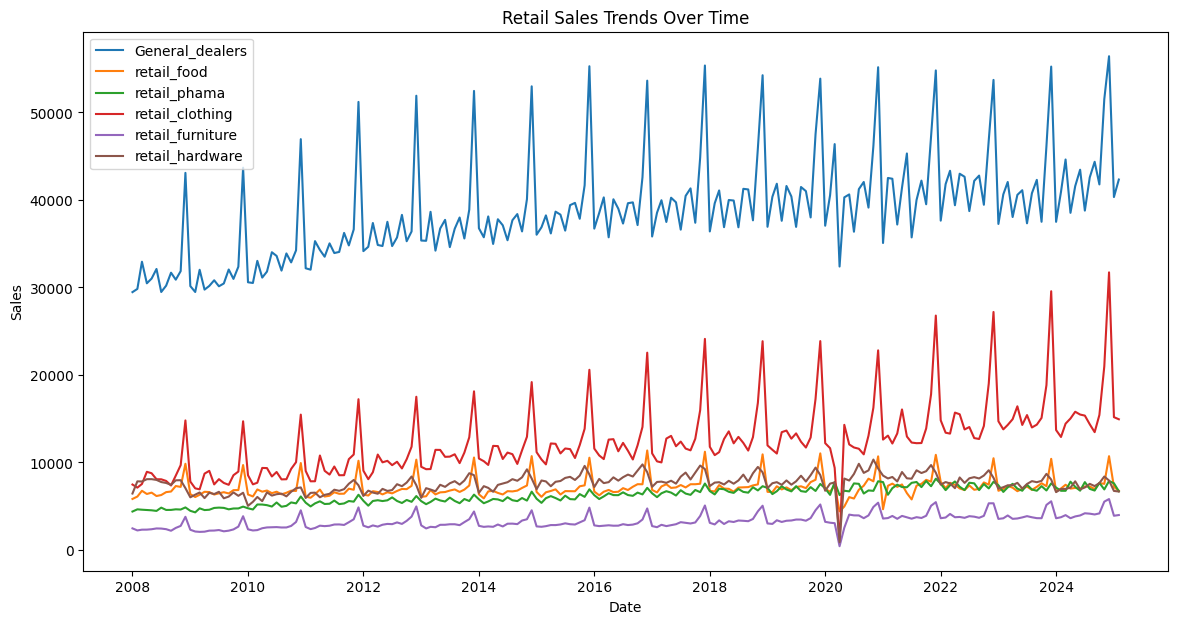

In [10]:
# Step 7: Time Series Trends
plt.figure(figsize=(14,7))
for col in numeric_cols:
    plt.plot(df['Date'], df[col], label=col)
plt.title('Retail Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

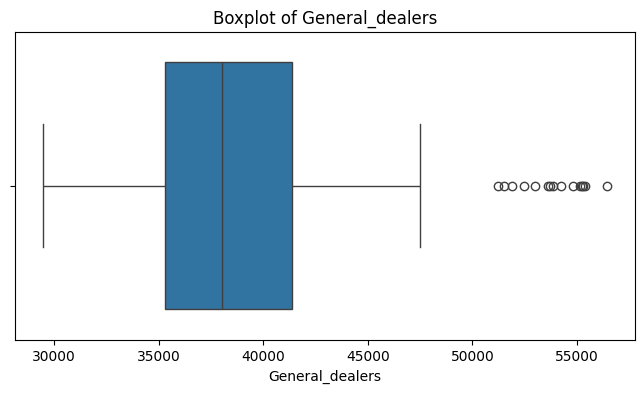

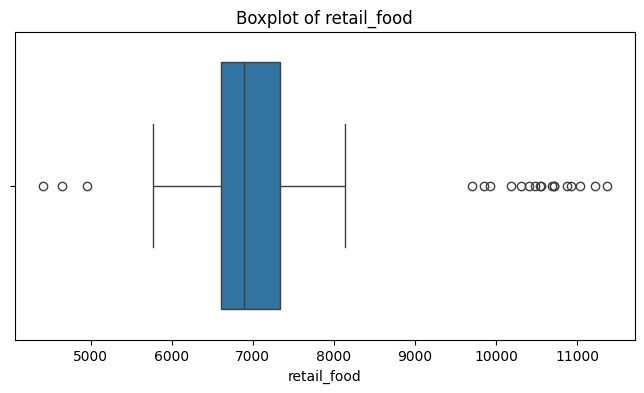

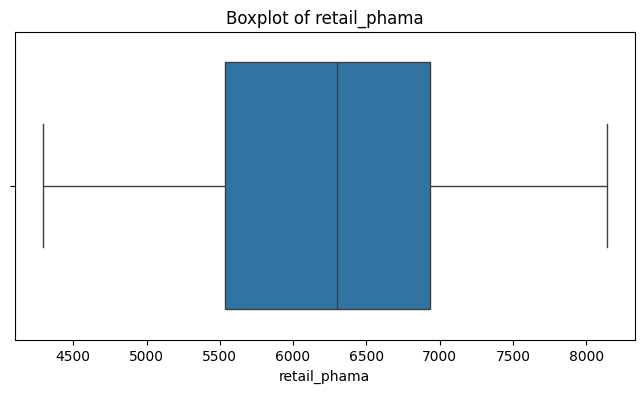

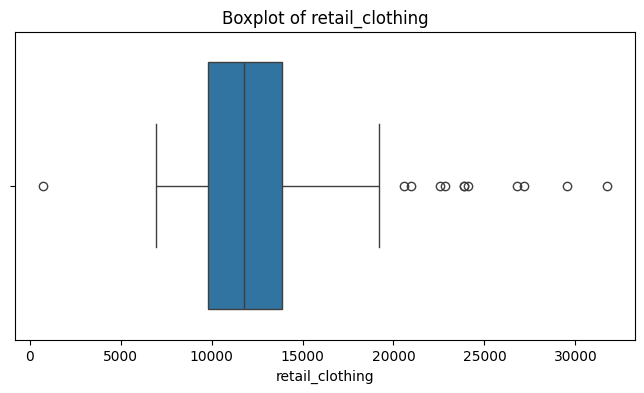

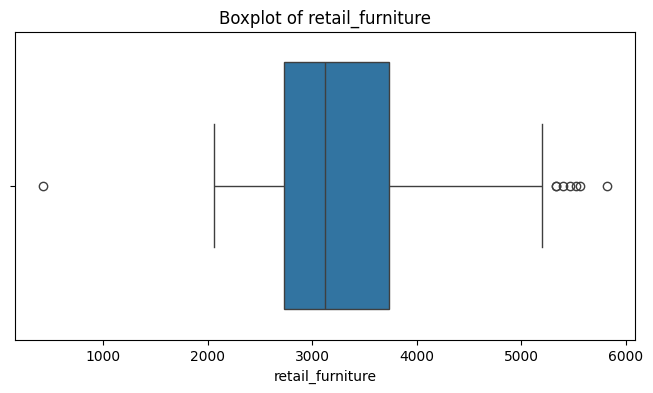

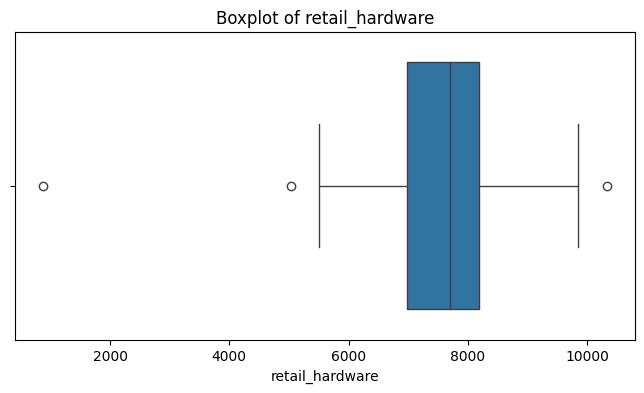

In [11]:
# Step 8: Outlier Detection
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [12]:
# Drop rows where ANY value is missing
df = df.dropna()

<Figure size 1200x600 with 0 Axes>

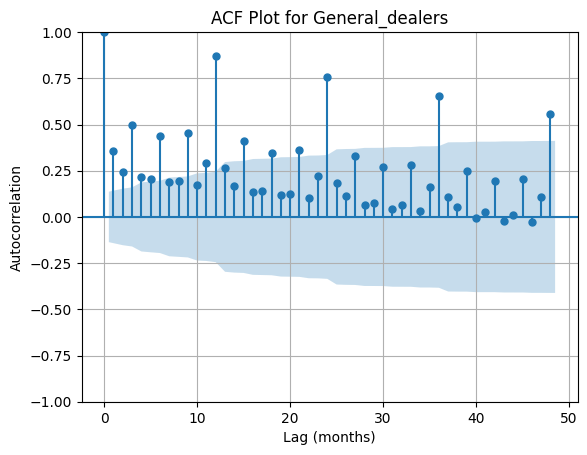

<Figure size 1200x600 with 0 Axes>

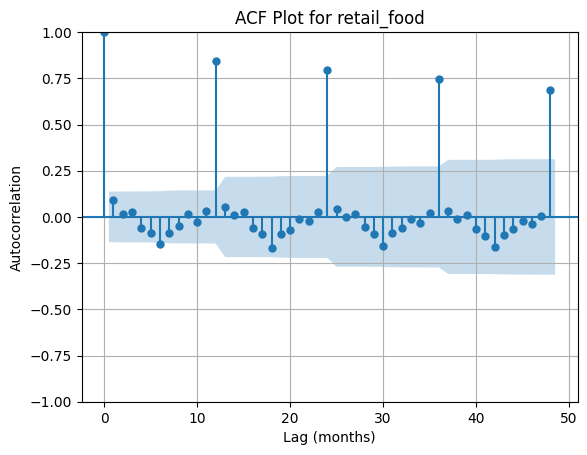

<Figure size 1200x600 with 0 Axes>

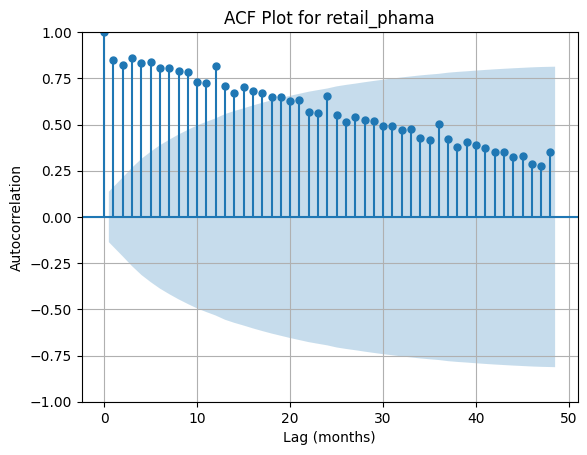

<Figure size 1200x600 with 0 Axes>

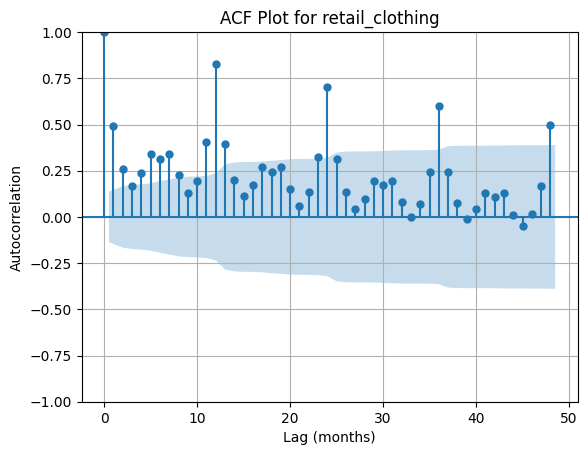

<Figure size 1200x600 with 0 Axes>

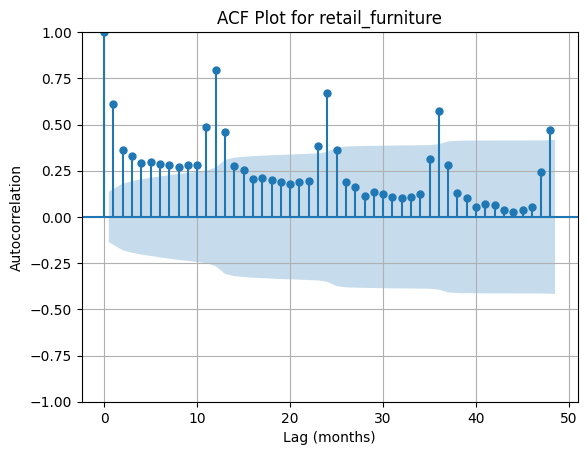

<Figure size 1200x600 with 0 Axes>

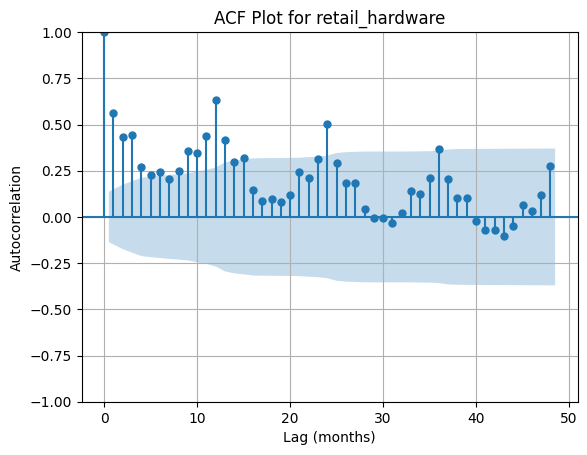

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Make sure 'Date' is datetime index
df.index = pd.to_datetime(df.index)

# Sales columns
sales_cols = ['General_dealers', 'retail_food', 'retail_phama', 'retail_clothing', 'retail_furniture', 'retail_hardware']

# Plot ACF for each sales column
for col in sales_cols:
    plt.figure(figsize=(12,6))
    plot_acf(df[col].dropna(), lags=48)  # 48 lags = 4 years if monthly
    plt.title(f'ACF Plot for {col}')
    plt.xlabel('Lag (months)')
    plt.ylabel('Autocorrelation')
    plt.grid()
    plt.show()



XGBoost Modeling

---




Retail trade sales for General dealers (code con_S621C) are reported at constant prices in actual values, measured in R million.

---



In [14]:
# Step 1: Prepare Data
print("\n Decomposing and Feature Engineering...")
df.index = pd.to_datetime(df.index)

decomposition = seasonal_decompose(df['General_dealers'], model='additive', period=12)
df['trend'] = decomposition.trend
df['seasonal'] = decomposition.seasonal
df['residual'] = decomposition.resid

df['General_dealers_lag1'] = df['General_dealers'].shift(1)
df['General_dealers_lag2'] = df['General_dealers'].shift(2)
df['General_dealers_lag3'] = df['General_dealers'].shift(3)
df['General_dealers_lag3'] = df['General_dealers'].shift(4)
df['General_dealers_lag3'] = df['General_dealers'].shift(5)
df['General_dealers_lag3'] = df['General_dealers'].shift(6)
df['General_dealers_roll3'] = df['General_dealers'].rolling(window=3).mean()
df['General_dealers_roll6'] = df['General_dealers'].rolling(window=6).mean()

df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year

df_model = df.dropna()
print(f" Features created. Dataset shape: {df_model.shape}")

FEATURES = ['General_dealers_lag1', 'General_dealers_lag2', 'General_dealers_lag3',
            'General_dealers_roll3', 'General_dealers_roll6', 'trend', 'seasonal', 'Month', 'Quarter', 'Year']
TARGET = 'General_dealers'

X_full = df_model[FEATURES]
y_full = df_model[TARGET]


 Decomposing and Feature Engineering...
 Features created. Dataset shape: (194, 18)


In [15]:
# Step 2: Split into Initial Train/Test
initial_train_size = int(len(X_full) * 0.8)

X_train = X_full.iloc[:initial_train_size]
y_train = y_full.iloc[:initial_train_size]

X_test = X_full.iloc[initial_train_size:]
y_test = y_full.iloc[initial_train_size:]

print(f" Initial training size: {X_train.shape[0]} | Test size: {X_test.shape[0]}")



 Initial training size: 155 | Test size: 39


In [16]:
# Step 3: Set parameter grid for fast tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [1, 1.5]
}

In [17]:
# Step 4: Walk-forward with tuning
predictions = []
true_values = []

print("\n🚶 Starting walk-forward prediction with tuning inside loop...")

for i in range(len(X_test)):
    print(f"\n Step {i+1}/{len(X_test)}:")

    # 4.1 Hyperparameter tuning
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=10,  # Try 10 random combinations only for speed
        scoring='neg_root_mean_squared_error',
        cv=3,
        verbose=0,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    print(f" Best params: {random_search.best_params_}")

    # 4.2 Predict the next point
    y_pred = best_model.predict(X_test.iloc[[i]])

    predictions.append(y_pred[0])
    true_values.append(y_test.iloc[i])

    # 4.3 Expand training set
    X_train = pd.concat([X_train, X_test.iloc[[i]]])
    y_train = pd.concat([y_train, y_test.iloc[[i]]])

print("\n Walk-forward with tuning completed.")


🚶 Starting walk-forward prediction with tuning inside loop...

 Step 1/39:
 Best params: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}

 Step 2/39:
 Best params: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}

 Step 3/39:
 Best params: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}

 Step 4/39:
 Best params: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}

 Step 5/39:
 Best params: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}

 Step 6/39:
 Best params: {'subsample': 0.8, '

In [18]:
# Step 5: Evaluate
rmse = np.sqrt(mean_squared_error(true_values, predictions))
print(f"\n Final Walk-Forward RMSE after tuning: {rmse:.2f}")


 Final Walk-Forward RMSE after tuning: 1074.36


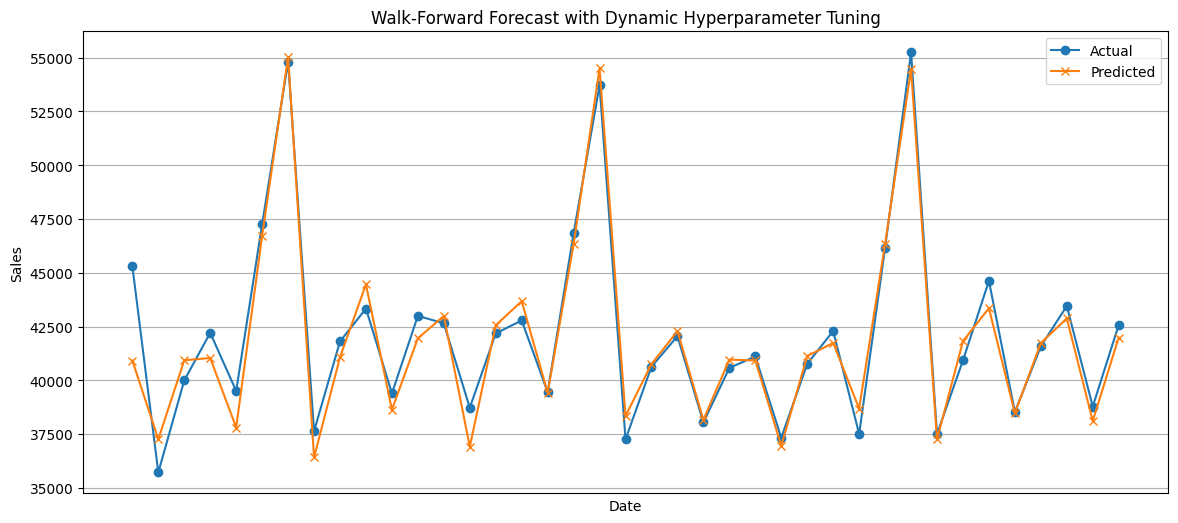


 Full dynamic walk-forward tuning and forecasting done!


In [19]:
# Step 6: Plot
plt.figure(figsize=(14,6))
plt.plot(y_test.index, true_values, label='Actual', marker='o')
plt.plot(y_test.index, predictions, label='Predicted', marker='x')
plt.title('Walk-Forward Forecast with Dynamic Hyperparameter Tuning')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

print("\n Full dynamic walk-forward tuning and forecasting done!")


In [20]:
# Step 7: Predict the next month
print("\n🔮 Predicting the next unseen month...")

# 7.1 Create the next month's feature row
last_row = df_model.iloc[-1]

next_month = (last_row.name + pd.DateOffset(months=1))
next_month_features = {}

next_month_features['General_dealers_lag1'] = last_row['General_dealers']
next_month_features['General_dealers_lag2'] = last_row['General_dealers_lag1']
next_month_features['General_dealers_lag3'] = last_row['General_dealers_lag2']
next_month_features['General_dealers_roll3'] = df_model['General_dealers'].iloc[-3:].mean()
next_month_features['General_dealers_roll6'] = df_model['General_dealers'].iloc[-6:].mean()
next_month_features['trend'] = np.nan  # We don't have trend for future
next_month_features['seasonal'] = decomposition.seasonal.iloc[(last_row.name.month % 12) - 1]
next_month_features['Month'] = next_month.month
next_month_features['Quarter'] = (next_month.month - 1) // 3 + 1
next_month_features['Year'] = next_month.year

# Convert to DataFrame
next_month_df = pd.DataFrame([next_month_features])

# 7.2 Fill missing values if any
next_month_df = next_month_df.fillna(method='ffill').fillna(method='bfill')

# 7.3 Retrain the final model on the entire dataset
final_model = xgb.XGBRegressor(**random_search.best_params_, objective='reg:squarederror', random_state=42)
final_model.fit(X_full, y_full)

# 7.4 Predict
next_month_prediction = final_model.predict(next_month_df)

print(f"\n📅 Next month predicted value : {next_month_prediction[0]:.2f}")



🔮 Predicting the next unseen month...

📅 Next month predicted value : 40682.54


<ipython-input-20-f510cbff0bb2>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  next_month_df = next_month_df.fillna(method='ffill').fillna(method='bfill')
